# Import required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Modules for SciBert
from transformers import AutoTokenizer, AutoModel
import torch

# Modules for calculating diversity of research topics
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy

# Module for conducting repeated-measure tests
from scipy.stats import wilcoxon
from scipy.stats import shapiro
import statsmodels.api as sm

# Ignore warning messages (only) for display purpose
import warnings
warnings.filterwarnings('ignore')

# Read data

In [2]:
# Read dataframe
df = pd.read_csv("../database/preprocessed_content_analysis.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,first_name,middle_name,last_name,email,institution,award_year,award_amount,paper_title,journal,publication_year,...,citation_2019,citation_2020,citation_2021,citation_2022,citation_2023,citation_2024,tokenized_title,normalized_title,tokenized_abstract,normalized_abstract
0,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,Effect of oxidation and geometrical dimensions...,Desalination,2011,...,13,5,10,5,7,1,"['Effect', 'of', 'oxidation', 'and', 'geometri...","['effect', 'oxidation', 'geometrical', 'dimens...","['This', 'study', 'reports', 'for', 'the', 'fi...","['study', 'report', 'time', 'use', 'oxidize', ..."
1,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,Synthesis and biological evaluation of new pyr...,Molecules,2014,...,13,5,10,5,7,1,"['Synthesis', 'and', 'biological', 'evaluation...","['synthesis', 'biological', 'evaluation', 'new...","['A', 'selected', 'set', 'of', 'substituted', ...","['select', 'set', 'substituted', 'pyridone', '..."
2,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,"Synthesis of 6-Ethyl-1, 2, 9-trioxopyrrolo [3,...",Zeitschrift für Naturforschung B,2013,...,13,5,10,5,7,1,"['Synthesis', 'of', '6', 'Ethyl-1', '2', '9', ...","['synthesis', 'ethyl-1', 'trioxopyrrolo', 'f',...","['Interaction', 'of', '6', 'amino-1', 'ethyl-4...","['interaction', 'amino-1', 'ethyl-4', 'oxoquin..."
3,Talal,NaN,Asad,talalasad@earthlink.net,cuny graduate school university center,2011,19901,"Randa M. Al-As’ ada, Mustafa M. El-abadelaha, ...",Z. Naturforsch,2013,...,13,5,10,5,7,1,"['Randa', 'M.', 'Al', 'As', 'ada', 'Mustafa', ...","['randa', 'm.', 'al', 'ada', 'mustafa', 'm.', ...","['Interaction', 'of', '6', 'amino-1', 'ethyl-4...","['interaction', 'amino-1', 'ethyl-4', 'oxoquin..."
4,Leaf,NaN,Van Boven,vanboven@colorado.edu,university of colorado at boulder,2011,250000,Identifiable but not identical: Combining soci...,Journal of Consumer research,2012,...,868,1234,1132,1198,1222,179,"['Identifiable', 'but', 'not', 'identical', 'C...","['identifiable', 'identical', 'combine', 'soci...","['How', 'do', 'consumers', 'reconcile', 'confl...","['consumer', 'reconcile', 'conflicting', 'moti..."


In [3]:
df.groupby('email').count()

,first_name,middle_name,last_name,institution,award_year,award_amount,paper_title,journal,publication_year,coauthors,...,citation_2019,citation_2020,citation_2021,citation_2022,citation_2023,citation_2024,tokenized_title,normalized_title,tokenized_abstract,normalized_abstract
email,,,,,,,,,,,,,,,,,,,,,
00t0holtgrav@bsu.edu,48,0,48,48,48,48,48,48,48,48,...,48,48,48,48,48,48,48,48,48,48
a.satpute@northeastern.edu,35,0,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
aabrewer@uci.edu,25,0,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
aag6@psu.edu,28,0,28,28,28,28,28,28,28,28,...,28,28,28,28,28,28,28,28,28,28
aam72@georgetown.edu,39,39,39,39,39,39,39,39,39,39,...,39,39,39,39,39,39,39,39,39,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zkrizan@iastate.edu,26,0,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26
zoe.wool@rice.edu,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
zook@uky.edu,120,0,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120


In [4]:
df.columns

Index(['first_name', 'middle_name', 'last_name', 'email', 'institution',
       'award_year', 'award_amount', 'paper_title', 'journal',
       'publication_year', 'coauthors', 'paper_abstract',
       'paper_total_citations', 'citation_2001', 'citation_2002',
       'citation_2003', 'citation_2004', 'citation_2005', 'citation_2006',
       'citation_2007', 'citation_2008', 'citation_2009', 'citation_2010',
       'citation_2011', 'citation_2012', 'citation_2013', 'citation_2014',
       'citation_2015', 'citation_2016', 'citation_2017', 'citation_2018',
       'citation_2019', 'citation_2020', 'citation_2021', 'citation_2022',
       'citation_2023', 'citation_2024', 'tokenized_title', 'normalized_title',
       'tokenized_abstract', 'normalized_abstract'],
      dtype='object')

# Use SciBERT to construct embeddings of each paper's abstract

In [5]:
# Load SciBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

In [6]:
embeddings_path = "../database/abstract_embeddings.npz"

if os.path.exists(embeddings_path):
    npz_file = np.load(embeddings_path)
    df['abstract_embedding'] = [npz_file[key] for key in npz_file.files]
else:
    embeddings_dict = {}
    for index, row in df.iterrows():
        text = row['paper_abstract']
        encoded_input = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)

        with torch.no_grad():
            output = model(**encoded_input)

        embedding = output.pooler_output.cpu().detach().numpy().flatten()
        embeddings_dict[f'embedding_{index}'] = embedding
    
    # Save embeddings as .npz
    np.savez(embeddings_path, **embeddings_dict)

Visualize the embedding (take James Evans as a case study)

# Use repeated-measure test to test the effect of funding on diversity of publication

In [7]:
# Add a column indicating whether the specific publication is before or after NSF award
# Here, we take publication year which is the same as award year as "before_award"
df["before_after_award"] = np.where(df["publication_year"] <= df["award_year"], "before_award", "after_award")

In [8]:
# Stacks the embedding matrices together (grouped by `author` and `before_after_award`)
group_by_embedding = df.groupby(by=["email", "before_after_award"])['abstract_embedding'].apply(lambda x: np.vstack(x)).reset_index(name='embedding_matrix')
group_by_embedding

,email,before_after_award,embedding_matrix
0,00t0holtgrav@bsu.edu,after_award,"[[-0.32955742, -0.5743396, -0.97046256, 0.2215..."
1,00t0holtgrav@bsu.edu,before_award,"[[-0.30634096, -0.4522231, -0.97391766, -0.939..."
2,a.satpute@northeastern.edu,after_award,"[[-0.32639113, -0.16873796, -0.15368238, 0.286..."
3,a.satpute@northeastern.edu,before_award,"[[-0.3914881, -0.11487491, -0.9629283, -0.3523..."
4,aabrewer@uci.edu,after_award,"[[-0.4823957, -0.40220445, -0.99880356, -0.968..."
...,...,...,...
4022,zook@uky.edu,before_award,"[[-0.055216346, -0.15407999, -0.9122512, 0.754..."
4023,zulu@msu.edu,after_award,"[[-0.15892313, -0.11903335, -0.9209364, -0.578..."
4024,zulu@msu.edu,before_award,"[[-0.27684975, -0.20300557, -0.6392335, 0.1452..."
4025,zygmunt.frajzyngier@colorado.edu,after_award,"[[-0.26335523, -0.17618415, -0.17456537, 0.923..."


In [9]:
# Remove authors (emails) with either no before_award or no_award
before_after_count = group_by_embedding.groupby(by='email')['before_after_award'].count()
filtered_email = before_after_count.index[np.where(before_after_count < 2)[0].tolist()]

group_by_embedding = group_by_embedding[~group_by_embedding['email'].isin(filtered_email)]
group_by_embedding

,email,before_after_award,embedding_matrix
0,00t0holtgrav@bsu.edu,after_award,"[[-0.32955742, -0.5743396, -0.97046256, 0.2215..."
1,00t0holtgrav@bsu.edu,before_award,"[[-0.30634096, -0.4522231, -0.97391766, -0.939..."
2,a.satpute@northeastern.edu,after_award,"[[-0.32639113, -0.16873796, -0.15368238, 0.286..."
3,a.satpute@northeastern.edu,before_award,"[[-0.3914881, -0.11487491, -0.9629283, -0.3523..."
4,aabrewer@uci.edu,after_award,"[[-0.4823957, -0.40220445, -0.99880356, -0.968..."
...,...,...,...
4022,zook@uky.edu,before_award,"[[-0.055216346, -0.15407999, -0.9122512, 0.754..."
4023,zulu@msu.edu,after_award,"[[-0.15892313, -0.11903335, -0.9209364, -0.578..."
4024,zulu@msu.edu,before_award,"[[-0.27684975, -0.20300557, -0.6392335, 0.1452..."
4025,zygmunt.frajzyngier@colorado.edu,after_award,"[[-0.26335523, -0.17618415, -0.17456537, 0.923..."


## (Pairwise) Distance-based approach

### Mean of cosine distance

In [10]:
# Define a function to calculate the mean cosine distance within the embedding 
# matrix of the author's publications (either before or after NSF funding)
def calculate_mean_cosine_distance(embedding_matrix):
    cosine_distance = pdist(embedding_matrix, 'cosine')
    cosine_distance_matrix = squareform(cosine_distance)
    mean_cosine_distance = np.mean(cosine_distance_matrix)

    return mean_cosine_distance

group_by_embedding["mean_cosine_distance"] = group_by_embedding["embedding_matrix"].\
    apply(lambda row: calculate_mean_cosine_distance(row))

In [11]:
# Convert the dataframe about mean_cosine_distance from long to wide format
mean_cosine_distance_wide = group_by_embedding.pivot(index='email', 
                                                     columns='before_after_award', 
                                                     values='mean_cosine_distance')
mean_cosine_distance_wide.columns.name = None
mean_cosine_distance_wide

,after_award,before_award
email,,
00t0holtgrav@bsu.edu,0.225915,0.264751
a.satpute@northeastern.edu,0.236865,0.253264
aabrewer@uci.edu,0.227764,0.276672
aag6@psu.edu,0.365709,0.298098
aam72@georgetown.edu,0.210023,0.251496
...,...,...
zkrizan@iastate.edu,0.370208,0.305669
zoe.wool@rice.edu,0.162485,0.198947
zook@uky.edu,0.277160,0.238168


In [12]:
# Calculate difference in mean_cosine_distance
mean_cosine_distance_wide['mean_diff'] = mean_cosine_distance_wide['after_award'] - mean_cosine_distance_wide['before_award']

#### Check descriptive statistics of difference in mean_cosine_distance

In [13]:
mean_cosine_distance_wide.apply(np.mean, axis=0)

after_award     0.251614
before_award    0.257974
mean_diff      -0.006360
dtype: float64

[Text(0.5, 1.0, 'Boxplot of Difference in Mean Cosine Distance')]

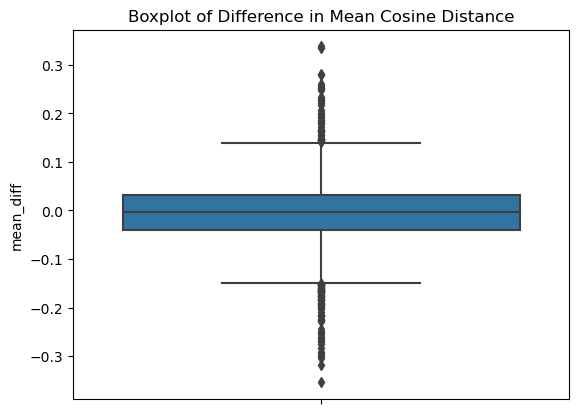

In [14]:
sns.boxplot(y=mean_cosine_distance_wide['mean_diff']).\
    set(title='Boxplot of Difference in Mean Cosine Distance')

#### Check assumptions (for paired-sample t-test)

In [15]:
shapiro(mean_cosine_distance_wide['mean_diff'])

ShapiroResult(statistic=0.961269736289978, pvalue=1.1662562536820683e-22)

Text(0.5, 1.0, 'Q-Q Plot of Difference in Mean Cosine Distance')

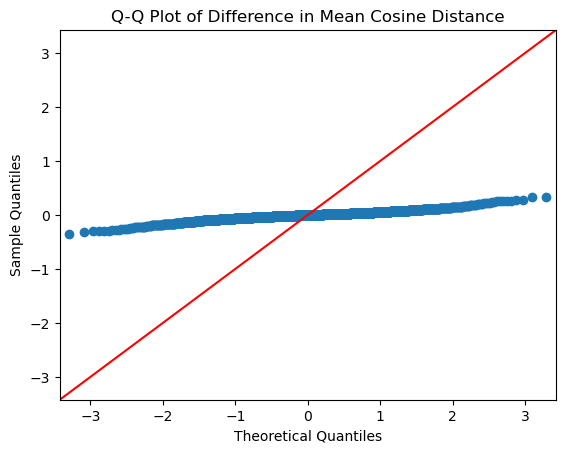

In [16]:
sm.qqplot(mean_cosine_distance_wide['mean_diff'], line ='45') 
plt.title('Q-Q Plot of Difference in Mean Cosine Distance')

Both the results of Shapiro-Wilk test and QQ-plot indicates the assumption of normality (of error) is violated. Hence, we will use the non-parametric version of paired-sample t-test, i.e., **Wilcoxon signed-rank test**.

In [17]:
wilcoxon(mean_cosine_distance_wide['mean_diff'])

WilcoxonResult(statistic=901785.0, pvalue=0.0010384179908780348)

In [18]:
# Define a function using bootstrapping to calculate confidence interval of mean difference
def bootstrap_effect_size(group1, group2, n_bootstrap=10000):
    np.random.seed(42)
    bootstrapped_means_diff = []

    for _ in range(n_bootstrap):
        boot_group1 = np.random.choice(group1, size=len(group1), replace=True)
        boot_group2 = np.random.choice(group2, size=len(group2), replace=True)
        bootstrapped_means_diff.append(boot_group2.mean() - boot_group1.mean())

    # Calculate the 95% confidence interval
    lower, upper = np.percentile(bootstrapped_means_diff, [2.5, 97.5])
    
    return np.mean(bootstrapped_means_diff), lower, upper

In [19]:
mean_diff, ci_lower, ci_upper = bootstrap_effect_size(\
    mean_cosine_distance_wide['before_award'],
    mean_cosine_distance_wide['after_award'])

print(f"Mean Difference (after_award - before_award): {mean_diff}, 95% CI: [{ci_lower}, {ci_upper}]")

Mean Difference (after_award - before_award): -0.006341889082910074, 95% CI: [-0.010373143294593618, -0.00219632177906876]


**Discussion**:

Both the results of Wilcoxon signed-rank test and bootstrapped confidence interval of mean difference indicate that there is a significant difference between the research topic diversity before and after an author receives the NSF funding. Specifically, an author's diversity of research topics decrease after receiving the NSF funding.

### Entropy of consine distance

In [20]:
# Define a function to calculate the entropy of cosine distance within the embedding 
# matrix of the author's publications (either before or after NSF funding): A 
# higher entropy value suggests a more diverse or spread-out set of distances
def calculate_cosine_distance_entropy(embedding_matrix):
    cosine_distance = pdist(embedding_matrix, 'cosine')
 
    # Normalize cosine distances to sum to 1
    distance_probabilities = cosine_distance / np.sum(cosine_distance)
    cosine_distance_entropy = entropy(distance_probabilities, base=2)

    return cosine_distance_entropy

group_by_embedding["cosine_distance_entropy"] = group_by_embedding["embedding_matrix"].\
    apply(lambda row: calculate_cosine_distance_entropy(row))

In [21]:
# Convert the dataframe about mean_cosine_distance from long to wide format
cosine_distance_entropy_wide = group_by_embedding.pivot(index='email', 
                                                        columns='before_after_award', 
                                                        values='cosine_distance_entropy')
cosine_distance_entropy_wide.columns.name = None
cosine_distance_entropy_wide

,after_award,before_award
email,,
00t0holtgrav@bsu.edu,7.905158,7.894687
a.satpute@northeastern.edu,7.607206,6.310275
aabrewer@uci.edu,4.728154,6.931941
aag6@psu.edu,6.059200,6.532294
aam72@georgetown.edu,6.869627,7.620829
...,...,...
zkrizan@iastate.edu,5.583540,6.436101
zoe.wool@rice.edu,4.302202,5.043054
zook@uky.edu,10.195597,10.938481


#### Check descriptive statistics of difference in cosine_distance_entropy

In [22]:
cosine_distance_entropy_wide['entropy_diff'] = cosine_distance_entropy_wide['after_award'] - cosine_distance_entropy_wide['before_award']
print(len(cosine_distance_entropy_wide))
# Drop missing values
cosine_distance_entropy_wide.dropna(axis=0, inplace=True)
print(len(cosine_distance_entropy_wide))

1993
1992


In [23]:
cosine_distance_entropy_wide.apply(np.mean, axis=0)

after_award     6.585283
before_award    7.211661
entropy_diff   -0.626379
dtype: float64

[Text(0.5, 1.0, 'Boxplot of Difference in Entropy of Cosine Distance')]

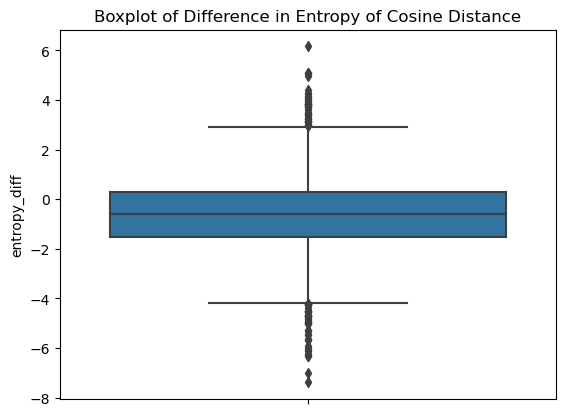

In [24]:
sns.boxplot(y=cosine_distance_entropy_wide['entropy_diff']).\
    set(title='Boxplot of Difference in Entropy of Cosine Distance')

#### Check assumptions (for paired-sample t-test)

In [25]:
shapiro(cosine_distance_entropy_wide['entropy_diff'])

ShapiroResult(statistic=0.9842143058776855, pvalue=4.9561263160960087e-14)

Text(0.5, 1.0, 'Q-Q Plot of Difference in Entropy of Cosine Distance')

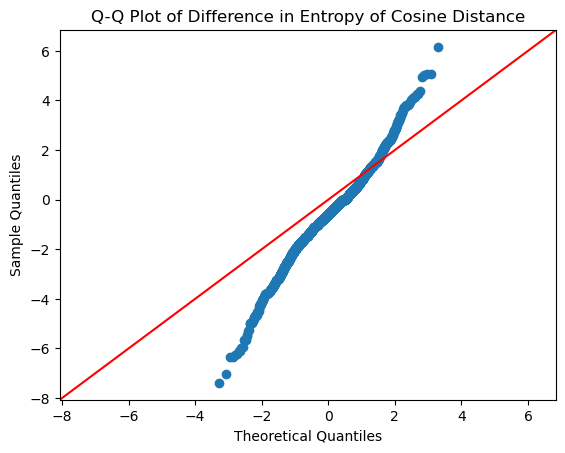

In [26]:
sm.qqplot(cosine_distance_entropy_wide['entropy_diff'], line ='45') 
plt.title('Q-Q Plot of Difference in Entropy of Cosine Distance')

Both the results of Shapiro-Wilk test and QQ-plot indicates the assumption of normality (of error) is violated. Hence, we will use the non-parametric version of paired-sample t-test, i.e., **Wilcoxon signed-rank test**.

In [27]:
wilcoxon(cosine_distance_entropy_wide['entropy_diff'])

WilcoxonResult(statistic=529957.0, pvalue=1.1430101155707752e-66)

In [28]:
mean_diff, ci_lower, ci_upper = bootstrap_effect_size(\
    cosine_distance_entropy_wide['before_award'],
    cosine_distance_entropy_wide['after_award'])

print(f"Mean Difference (after_award - before_award): {mean_diff}, 95% CI: [{ci_lower}, {ci_upper}]")

Mean Difference (after_award - before_award): -0.6266795638734182, 95% CI: [-0.8158749414923414, -0.4419406910758808]


**Discussion**:

Both the results of Wilcoxon signed-rank test and bootstrapped confidence interval of mean difference indicate that there is a significant difference between the research topic diversity before and after an author receives the NSF funding. Specifically, an author's diversity of research topics decrease after receiving the NSF funding.

Together with the the results of mean_cosine_distance, distance-based approach provides strong support for the **"trap" of research funding** (in terms of research diversity).